# Tutorial: Using SQL Query for Timeseries Analysis

Driven by the rise of IoT devices, IT systems, and smart industrial machines, time-series data, i.e. data that measures how things change over time, is one of the fastest growing data types. Time-series data has specific characteristics such as typically arriving in time order form, current data having dependence on historic data, and queries being over a time segment. In order to analyze this data efficiently, we created the Timeseries Toolkit that provides:
- runtime capabilities for data transformations. Quickly prepare and analyze time-series data with built-in analytic functions such as  segmentation, smoothing, join and interpolation.
- statistical and machine learning capabilities to perform timeseries-based analysis including forecasting, clustering and frequent itemset mining.

This notebook serves as a self-service tutorial that uses [IBM Cloud SQL query](https://www.ibm.com/cloud/sql-query), [IBM Cloud Object Storage](https://www.ibm.com/cloud/object-storage) and advanced IBM Timeseries analytics technology to guide the user through an end-to-end process of preparing and analyzing IoT type data with timestamps and location information. This tutorial leverages some of the advanced timeseries analytic capabilities such as timeseries alignment, segmentation and forecasting.

The Timeseries Toolkit comes fully integrated with Apache Spark and in doing so is capable of effectively scaling the analysis. It provides the ability to handle timeseries data of any data type (doubles, strings, geo-locations etc.), data that may be unaligned or non-periodic and as such can be used in a variety of applications. For example, you can easily store and analyze metric and log data for DevOps, sensor data for IoT applications, network traffic data, and industrial telemetry data for equipment maintenance. 

The Timeseries toolkit at its core is written in Java and Scala (for Spark extensions) and can be seamlessly integrated with your Java code. It also comes with Python APIs to facilitate data exploration via notebooks, thus enabling the analyst to take advantage of the rich ML ecosystem in python such as scikit-learn, tensorflow and pytorch. We have also added SQL interface wherein a timeseries is now a native SQL type, and operations on such timeseries can be performed via SQL queries via UDFs.  This feature enables us to deploy the toolkit out-of-the-box in IBM Cloud SQL Query and be used through serverless SQL jobs.

This notebook describes a simple analytics pipeline, illustrating some of the common steps one might use in the analysis of timeseries data such as: 
1. [Setup](#setup)<br>
2. [Data Introduction](#data)<br>
3. [Data Cleanup and Alignment](#align)<br>
4. [Computing Correlations](#corr)<br>
5. [Segmentation](#seg)<br>
5. [Forecasting](#forecast)<br>

## <a name="setup"></a> 1. Setup

With native integration with IBM SQL Query, the setup is quick and simple and involves importing the 'ibmcloudsql' package into the notebook environment and setting up the appropriate authentication with the API key and tokens.

In [1]:
%%capture
!conda install pyarrow
!pip install --user ibmcloudsql
import ibmcloudsql
import getpass
targeturl=''

In [5]:
apikey=getpass.getpass('Enter IBM Cloud API Key (leave empty to use previous one): ') or apikey
instnacecrn=input('Enter SQL Query Instance CRN (leave empty to use previous one): ') or instnacecrn
if targeturl == '':
    targeturl=input('Enter target URL for SQL results: ')
else:
    targeturl=input('Enter target URL for SQL results (leave empty to use ' + targeturl + '): ') or targeturl
sqlClient = ibmcloudsql.SQLQuery(apikey, instnacecrn, client_info='Timeseries Demo Notebook')
sqlClient.logon()

Enter IBM Cloud API Key (leave empty to use previous one): ········
Enter SQL Query Instance CRN (leave empty to use previous one): 
Enter target URL for SQL results: cos://us-east/cloudant-results/


In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 6)})

## <a name="data"></a> 2. Data Introduction

We will use an open source dataset, the [OK Lab data](https://luftdaten.info/en/home-en/) that has been made available by the [Open Knowledge Foundation of Germany](http://okfn.de/).


The data consists of two types of sensors spread out across a wide region (primarily in Germany), one is a particulate sensor and the other is a temperature and humidity sensor. Particulate matter (PM) are of two types:

    PM10 inhalable particles, of diameter less than 10 micrometers
    PM2.5 inhalable particles, of diameter less than 2.5 micrometers

Particulate matter when inhaled can cause serious health conditions depending on the nature of the particles. A list of most polluted cities in the world through the measure of particulate matter concentration can be found [here](https://en.wikipedia.org/wiki/List_of_most-polluted_cities_by_particulate_matter_concentration).

In this particular installation, there are two types of sensors -- a temperature and humidity sensor (DHT) and a corresponding particulate matter (PM) count as described above. For a detailed introduction to Cloud SQL or the dataset used here, the user is referred to [this notebook](https://eu-gb.dataplatform.cloud.ibm.com/exchange/public/entry/view/5d686c16d14491f4c3997b67fe11506d). For the purpose of demonstrating timeseries functionality, we begin by preparing a dataset of a resonable duration i.e. lengths between 1000 and 2000 so that meaningful downstream analysis can be performed. The following three SQL statements achieve that, and the results are stored as csv files for future processing.

The input data is publicly available to every user of SQL Query in the COS bucket **cos://us-geo/sql**. We are using two data sets specifically:

-  **DHT (temperature and humidity): cos://us-geo/sql/oklabdata/parquet/dht22/**
-  **SDS (Particulate matter): cos://us-geo/sql/oklabdata/parquet/sds011/**

### Data ETL

In the first step, we extract the data from these buckets and create a list of locations that have between 1000 and 2000 data points from both DHT (humidity and temperature) and PM (particulate matter) sensors. An inner join is performed to select those locations that are common in both datasets. 

In [7]:
stmt = """
    WITH
        humidity_location_table AS (
        -- 1. Select locations from DHT where humidity is >70% and the length is data is between 1000 and 2000
            SELECT location from (
                SELECT 
                    COUNT(*) AS count,
                    location 
                FROM cos://us-geo/sql/oklabdata/parquet/dht22/2017/09/ STORED AS PARQUET
                WHERE humidity > 70.0
                GROUP BY location
            )
            WHERE count > 1000 AND count < 2000
        ),
        pm_location_table AS (
        -- 2. Select locations from PM where length is data is between 1000 and 2000
           SELECT location from (
            SELECT 
              COUNT(*) AS count,
              location 
            FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/09/ STORED AS PARQUET
            GROUP BY location
          )
          WHERE count > 1000 AND count < 2000
        )
        -- 3. Select those locations that are present in both PM and DHT tables
        SELECT
            humidity_location_table.location
        FROM humidity_location_table
        INNER JOIN pm_location_table
        ON humidity_location_table.location=pm_location_table.location
        INTO {}
""".format(targeturl)

location_job_id = sqlClient.submit_sql(stmt)
sqlClient.wait_for_job(location_job_id)
location_table = sqlClient.get_job(location_job_id)['resultset_location']


In the next two statements, we create the two parquet files needed for the purpose of this demonstration. First is the temperature_humidity_data file, which contains the temperature, humidity data for those locations that were extracted in the previous step. 

In [8]:
dht_table = targeturl + "temperature_humidity_data"

stmt = """
    SELECT raw_table.location, temperature, humidity, timestamp 
    FROM cos://us-geo/sql/oklabdata/parquet/dht22/2017/09/ STORED AS PARQUET AS raw_table
    INNER JOIN {} AS location_table
    ON raw_table.location=location_table.location
    INTO {} STORED AS PARQUET
""".format(location_table, dht_table)

dhs_raw_job_id = sqlClient.submit_sql(stmt.format(location_job_id=location_job_id))
sqlClient.wait_for_job(dhs_raw_job_id)
dht_raw_table = sqlClient.get_job(dhs_raw_job_id)['resultset_location']

In the final step of ETL, we create pm_data, which is the PM sensor table for those locations extracted in Step 1. 

In [9]:
pm_table = targeturl + "pm_data"

stmt = """
    SELECT raw_table.location, P1, timestamp
    FROM cos://us-geo/sql/oklabdata/parquet/sds011/2017/09/ STORED AS PARQUET AS raw_table
    INNER JOIN {}  AS location_table
    ON raw_table.location=location_table.location
    INTO {}  STORED AS PARQUET
""".format(location_table, pm_table)

pm_raw_job_id = sqlClient.submit_sql(stmt.format(location_job_id=location_job_id))
sqlClient.wait_for_job(pm_raw_job_id)
pm_raw_table = sqlClient.get_job(pm_raw_job_id)['resultset_location']

These steps complete the data preprocessing. 

#### <a name="stmt1"></a> Prepare Temperature & Humidity Data Set

Now, let us examine how we can use both these sensors to analyze the DHT (humidity and temperature) and PM (particulate matter) sensors. One can think of each sensor as generating a timeseries of readings of various sensors -- humidity, temperature, PM10, PM2.5. In the SQL statement [below](#stmt1), we first construct the timeseries for each location. We do this by using the TIME_SERIES UDF. The timestamp and temperature  fields are inputs to the TIME_SERIES function, and this creates a timeseries of temperature data; grouping by location ensures we have one series for each location. We store the result of this query back into a COS bucket for future queries.

In [10]:
stmt = """
    SELECT 
        location, 
        TIME_SERIES(TS_TIMESTAMP(timestamp), temperature) AS dht 
    FROM {} STORED AS PARQUET
    GROUP BY location 
    INTO {} STORED AS PARQUET
    
""".format(dht_raw_table, targeturl)

dht_job_id = sqlClient.submit_sql(stmt.format(dhs_raw_job_id=dhs_raw_job_id))
sqlClient.wait_for_job(dht_job_id)
dht_ts_table = sqlClient.get_job(dht_job_id)['resultset_location']

#### <a name="stmt2"></a> Examine Temperature & Humidity Data Set

The first step in analysis is to simply examine the data and obtain some basic statistics. For this, we use the `TS_DESCRIBE` function that will take a timeseries and explode it to various statistics about the timeseries itself such as first and last timestamp, mean, standard deviation etc.  Once the timeseries' are constructed, we use the `TS_DESCRIBE` to extract statistics for each of the timeseries. For example, we can use the `TS_DESCRIBE` method on this result table.

In [11]:
stmt = """
    SELECT 
        location, 
        TS_DESCRIBE(dht) 
    FROM {} STORED AS PARQUET
    INTO {}
""".format(dht_ts_table, targeturl)

sqlClient.run_sql(stmt.format(dht_job_id=dht_job_id))

,location,dht_time_min,dht_time_max,dht_time_mean,dht_mode,dht_unique,dht_frequency,dht_first_time_tick,dht_first_value,dht_last_time_tick,dht_last_value,dht_count,dht_num_mean,dht_num_std,dht_num_min,dht_num_max,dht_num_25,dht_num_50,dht_num_75
0,2996,144000,958000,147762.288477,17.0,62,68,1506632536000,15.9,1506815909000,13.9,1242,16.941868,1.646989,13.6,19.9,15.80,17.1,18.30
1,2975,133000,310000,147062.638581,17.5,157,78,1506550670000,15.3,1506815971000,10.3,1805,18.189418,3.563917,10.3,26.0,15.40,17.7,20.60
2,2989,139000,189000,146886.575736,14.7,245,39,1506611281000,21.1,1506815894000,13.9,1394,16.717001,6.554902,7.9,43.9,12.30,14.7,20.60
3,691,148000,924000,154860.354223,12.1,188,38,1504224066000,14.2,1504451401000,24.2,1469,17.180871,4.375705,10.7,33.5,14.00,16.2,19.70
4,1336,144000,21810000,189490.157480,14.9,102,52,1506519942000,24.2,1506808725000,14.1,1525,18.401770,2.790637,13.2,24.2,15.85,18.4,21.10
5,630,146000,475000,147097.266881,16.8,142,56,1506632964000,17.7,1506815953000,10.0,1245,16.982088,3.700473,10.0,25.1,15.70,16.9,18.95
6,971,145000,255896000,349080.952381,10.9,153,73,1505681057000,10.6,1506267513000,23.6,1681,13.908447,3.630632,9.8,26.3,11.00,12.6,16.00
7,2976,139000,305000,147073.251942,14.3,145,57,1506550864000,10.2,1506815890000,11.4,1803,15.284470,4.086815,8.8,24.0,12.50,14.1,18.90


#### <a name="stmt3"></a> Prepare Particulate Matter Data Set

Next, we look at the other sensor --  Particulate Matter (PM). Exactly as we did with [DHT data](#stmt1), we use TIME_SERIES but this time with timestamps and p1 as the inputs to create a timeseries of PM values and store it for future queries.

In [12]:
stmt = """
    SELECT 
        location, 
        TIME_SERIES(TS_TIMESTAMP(timestamp), p1) AS pm 
    FROM {} STORED AS PARQUET
    GROUP BY location 
    INTO {} STORED AS PARQUET
""".format(pm_raw_table, targeturl)

pm_job_id = sqlClient.submit_sql(stmt.format(pm_raw_job_id=pm_raw_job_id))
sqlClient.wait_for_job(pm_job_id)
pm_ts_table = sqlClient.get_job(pm_job_id)['resultset_location']

#### <a name="stmt4"></a> Examine Particulate Matter Data Set

Similar to our [earlier step](#stmt2), we use TS_DESCRIBE to examine the summary of the PM timestamps and sensor values. Since we had grouped by location, we have a timeseries of particulate matter for every location and consequently a summary statistic for every such location.

In [13]:
stmt = """
    SELECT 
        location, 
        TS_DESCRIBE(pm) 
    FROM {} STORED AS PARQUET
    INTO {}
""".format(pm_ts_table, targeturl)

sqlClient.run_sql(stmt.format(pm_job_id=pm_job_id))

,location,pm_time_min,pm_time_max,pm_time_mean,pm_mode,pm_unique,pm_frequency,pm_first_time_tick,pm_first_value,pm_last_time_tick,pm_last_value,pm_count,pm_num_mean,pm_num_std,pm_num_min,pm_num_max,pm_num_25,pm_num_50,pm_num_75
0,2996,144000,957000,147761.482675,33.22,1078,4,1506632536000,134.27,1506815908000,18.98,1242,71.949589,57.585319,5.30,247.02,33.295,52.54,98.3450
1,2975,132000,313000,147062.084257,9.27,770,13,1506550670000,19.47,1506815970000,35.13,1805,15.249224,9.179313,2.20,80.67,8.085,11.90,22.2150
2,2989,140000,190000,146885.857861,16.10,795,7,1506611281000,12.70,1506815893000,4.97,1394,15.153178,7.785469,3.30,114.05,9.040,14.40,20.3825
3,691,148000,924000,154860.354223,4.40,838,11,1504224065000,12.95,1504451400000,2.40,1469,16.737495,15.012647,1.70,135.30,5.885,10.63,23.5500
4,1336,145000,21810000,189489.501312,6.70,530,17,1506519942000,6.90,1506808724000,1.93,1525,10.641666,5.038553,1.00,29.17,6.915,10.40,13.8700
5,630,146000,475000,147096.463023,7.00,790,7,1506632964000,15.10,1506815952000,53.05,1245,18.340345,14.819907,2.50,91.97,6.550,12.82,27.1150
6,971,146000,255896000,348665.873960,0.80,413,32,1505681057000,1.40,1506267513000,5.97,1683,5.198010,4.158647,0.40,22.57,1.830,3.70,8.1300
7,2976,138000,305000,147073.251942,34.00,1439,4,1506550864000,83.97,1506815890000,2.27,1803,83.146717,105.683768,2.07,714.03,30.100,47.73,80.1000


## <a name="align"></a> 3. Data Cleanup and Alignment

The simplest cleanup task in this case is that of data alignment. We note that even though they are located at the same place, the PM and DHT sensors do not run on the same clock. This results in different timestamps for each of the sensors. Further, we note that the PM sensor is valid (according to the specification/data sheet) when humidity is <70%. A quick query (as shown below) on the DHT sensor data shows that there are numerous values of humidity that are >70%.

#### <a name="stmt5"></a> Check for inconsistent data

In [14]:
stmt = """
    SELECT COUNT(*) 
    FROM {} STORED AS PARQUET
    WHERE HUMIDITY > 70.0
    GROUP BY location
    LIMIT 10
    INTO {}
""".format(dht_raw_table, targeturl)
sqlClient.run_sql(stmt.format(dhs_raw_job_id=dhs_raw_job_id))

,count(1)
0,1242
1,1443
2,1031
3,1373
4,1204
5,1034
6,1681
7,1552


### Data Alignment

Data alignment is normally a very complex process as it involves aligning two timeseries whose timestamps may not be matching, and subsequently interpolating missing values. However this fundamental step is necessary to perform any downstream operation (e.g., selecting valid data for further analysis, correlations etc.). The Timeseries Toolkit makes the alignment very simple by providing in-built transforms for all common database joins - inner, outer, left, right and full. A complete list of align and join operations along with the functionality they provide may be accessed [here](https://github.ibm.com/Common-TimeSeries-Analytics-Library/SQL-Functions/blob/master/SQL_Functions.md). 

Let us look at an example of how to perform alignment using the data that we have been looking at -- DHT and PM. We would like to align these two sensor values for downstream analysis, whether it be simple question such as querying the humidity and particulate matter at time t, or creating a tensor of humidity and particulate matters over a range of time (t1, t2).
 
In queries [1](#stmt1) and [3](#stmt3), we created DHT and PM timeseries from data stored in COS. In order to align these series, we use the TS_FULL_ALIGN (we choose a full align here) and provide the two timeseries we created earlier as parameters and using location as the join criteria; it then outputs two timeseries that are aligned by their timestamps. The align operation makes the timestamps in the two series match; when a timestamp is missing in one of the series a NaN is used. A full align ensures that the joined dataset has every timestamp from both the datasets (where as a left align would retain all the timestamps in DHT in this example, filling in NaNs for PM). The results are stored back into COS in parquet format for future analysis.  

#### <a name="stmt6"></a> Joining multiple tables

In [15]:
stmt = """
    SELECT 
        dht_ts_table.location, 
        TS_FULL_ALIGN(dht, pm, TS_INTERPOLATOR_NEAREST(0.0))
    FROM {} STORED AS PARQUET AS dht_ts_table
    INNER JOIN {} STORED AS PARQUET AS pm_ts_table
    ON dht_ts_table.location = pm_ts_table.location
    INTO {} STORED AS PARQUET
""".format(dht_ts_table, pm_ts_table, targeturl)

dht_pm_job_id = sqlClient.submit_sql(stmt.format(dht_job_id=dht_job_id, pm_job_id=pm_job_id))
sqlClient.wait_for_job(dht_pm_job_id)
dht_pm_ts_table = sqlClient.get_job(dht_pm_job_id)['resultset_location']

#### <a name="stmt7"></a> Explode and Visualize Joined Data

The result of the previous query are timeseries named dht_aligned and pm_aligned (by default _aligned is assigned; users can specify desired names). Since the timeseries is a complex datatype (as constructed using the TIME_SERIES function in steps [1](#stmt1) and [3](#stmt3), we need it to be exploded to consume it easily in subsequent queries (or for visualization). In the following statement, we query the humidity and pm columns from the aligned, exploded tables on matching locations and timestamps using an INNER JOIN. Note that the align transform simply created matching timestamps but did not join them; if a join was desired the user would perform a TS_FULL_JOIN. For full align and join information, please refer to the documentation [here](https://github.ibm.com/Common-TimeSeries-Analytics-Library/SQL-Functions/blob/master/SQL_Functions.md).

We illustrate these steps [as follows](#stmt7), to select the aligned DHT and PM timeseries. We limit the number of results for ease of visualization. 

In [16]:
stmt = """
    WITH 
        dht_align_table AS (
            SELECT
                location,
                TS_EXPLODE(dht_aligned) as (timestamp, humidity)
            FROM {} STORED AS PARQUET),
        pm_align_table AS (
            SELECT
                location,
                TS_EXPLODE(pm_aligned) as (timestamp, pm)
            FROM {} STORED AS PARQUET)
    SELECT
        dht_align_table.location,
        dht_align_table.timestamp,
        humidity,
        pm
    FROM dht_align_table
    INNER JOIN pm_align_table
    ON dht_align_table.location=pm_align_table.location AND dht_align_table.timestamp=pm_align_table.timestamp
    LIMIT 20
    INTO {}   
""".format(dht_pm_ts_table,dht_pm_ts_table, targeturl)

sqlClient.run_sql(stmt.format(dht_pm_job_id=dht_pm_job_id))

,location,timestamp,humidity,pm
0,2996,1506632536000,15.9,134.27
1,2996,1506632683000,15.9,134.55
2,2996,1506632829000,15.8,133.50
3,2996,1506632976000,15.8,142.23
4,2996,1506633122000,15.8,145.35
5,2996,1506633123000,15.8,145.35
6,2996,1506633269000,15.8,150.60
7,2996,1506633416000,15.8,138.70
8,2996,1506633562000,15.8,142.15
9,2996,1506633563000,15.8,142.15


### <a name="clean"></a>  Data Cleaning 


When two timeseries are aligned "fully", it results in values that are null for those that do not have a corresponding timestamp. For example, if at time t1, DHT has humidity value of 27.3 and there is no corresponding value in PM for P2, the value for P2 is returned as null. This null value has to be filled for easy downstream consumption (and it depends on the application as to how to choose such a value). There are several options to do this using the TS_FILLNA that takes in a timeseries and an interpolator of choice. This interpolator can be different inbuilt options such as linear, nearest, or cubic spline. We use the nearest value interpolator in this case; however it is the application and developer's choice. 


#### <a name="stmt8"></a>Removing NaN via Interpolation

In [17]:
stmt = """
    SELECT 
        location, 
        TS_FILLNA(dht_aligned, TS_INTERPOLATOR_NEAREST(0.0)) as dht, 
        TS_FILLNA(pm_aligned, TS_INTERPOLATOR_NEAREST(0.0)) as pm 
    FROM {} STORED AS PARQUET
    INTO {} STORED AS PARQUET
""".format(dht_pm_ts_table, targeturl)

dht_pm_clean_job_id = sqlClient.submit_sql(stmt.format(dht_pm_job_id=dht_pm_job_id))
sqlClient.wait_for_job(dht_pm_clean_job_id)
dht_pm_clean_ts_table = sqlClient.get_job(dht_pm_clean_job_id)['resultset_location']

Combining the previous steps, the final version of the align query is demonstrated [below](#stmt9) --  where in the align is performed on the 'exploded' values as shown [here](#stmt7) and the 'cleaned' (i.e. NULLS removed) DHT and PM tables as shown [here](#stmt8). After interpolating the NULLS with nearest values, we now see that each timestamp has both humidity and corresponding P2 values e.g. at t1 we had no humdity value earlier, now we see the humidity of 27.3 has a correponding P2 value of 7.23.

We limit the number of results for ease of visualization.

#### <a name="stmt9"></a>Explode and Visualize Joined and Cleaned Data

In [18]:
stmt = """
    WITH 
        dht_align_table AS (
            SELECT
                location,
                TS_EXPLODE(dht) as (timestamp, humidity)
            FROM {} STORED AS PARQUET),
        pm_align_table AS (
            SELECT
                location,
                TS_EXPLODE(pm) as (timestamp, pm)
            FROM {} STORED AS PARQUET)
    SELECT
        dht_align_table.location,
        dht_align_table.timestamp,
        humidity,
        pm
    FROM dht_align_table
    INNER JOIN pm_align_table
    ON dht_align_table.location=pm_align_table.location AND dht_align_table.timestamp=pm_align_table.timestamp
    LIMIT 20
    INTO {}    
""".format(dht_pm_clean_ts_table,dht_pm_clean_ts_table,targeturl)

sqlClient.run_sql(stmt.format(dht_pm_clean_job_id=dht_pm_clean_job_id))

,location,timestamp,humidity,pm
0,2996,1506632536000,15.9,134.27
1,2996,1506632683000,15.9,134.55
2,2996,1506632829000,15.8,133.50
3,2996,1506632976000,15.8,142.23
4,2996,1506633122000,15.8,145.35
5,2996,1506633123000,15.8,145.35
6,2996,1506633269000,15.8,150.60
7,2996,1506633416000,15.8,138.70
8,2996,1506633562000,15.8,142.15
9,2996,1506633563000,15.8,142.15


## <a name="corr"></a> 4. Computing Correlations

Once we have the data aligned, cleaned of NULL and interpolated missing values, we might want to do statistical analysis on the data. Here, we look at a basic question "Is there a correlation between the particulate matter and temperature?" We provide various statistical functionalities inbuilt as a SQL UDF, including TS_CORRELATION. We simply provide the two timeseries (in this case DHT and PM) as arguments to TS_CORRELATION and obtain as output the correlation coefficient. 

#### <a name="stmt10"></a>Computing Correlations on Timeseries Data

In [19]:
stmt = """
    SELECT 
        location, 
        TS_CORRELATION(dht, pm) as correlation 
    FROM {} STORED AS PARQUET
    ORDER BY ABS(correlation) DESC
    INTO {}
""".format(dht_pm_clean_ts_table, targeturl)

df = sqlClient.run_sql(stmt.format(dht_pm_clean_job_id=dht_pm_clean_job_id))

Text(0.5,1,'Correlation between humidity and particulate matter for each location')

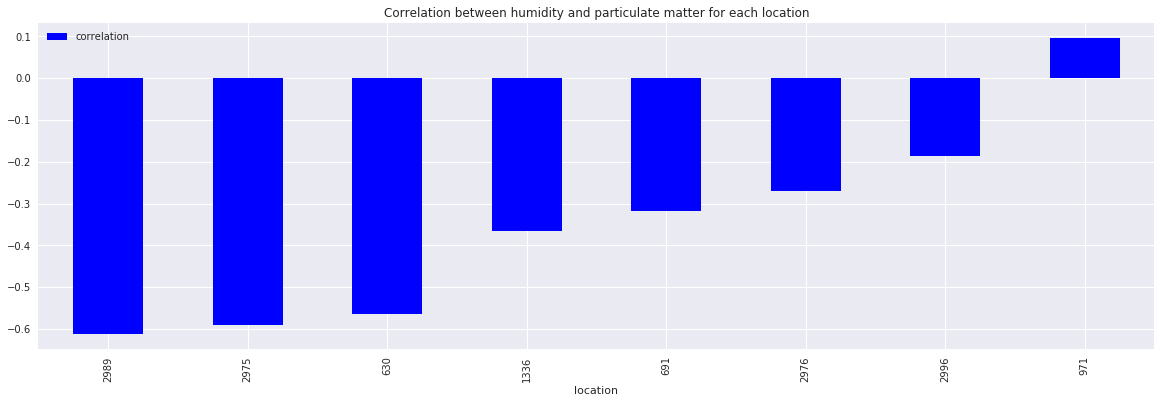

In [20]:
ax = df.plot(kind='bar', x='location', color='blue')
ax.set_title("Correlation between humidity and particulate matter for each location")

##  <a name="segment"></a>  Segmentation

Often times, we need to look at segments of the timeseries instead of the entire series. For example, we might want to look at hourly aggregates and compare how temperatures are changing in a day. This is an example of segmenting based on a time window (TS_SEGMENT_BY_TIME), wherein the number of records in each time segment could be varying. In certain cases, we may be interested in a paritcular event (TEMP > 70) which forms our "anchor" and we may want to provide a left and right window around the anchor to examine a segment of interest (TS_SEGMENT_BY_ANCHOR). We also provide the ability to simply segment by a fixed number of records.

In this example, we use TS_SEGMENT_BY_TIME to create hourly segments followed by TS_SEG_AVG to compute the average over each segment of the TimeSeries. We show how we can use the linear interpolator to fill in missing values into the resulting series.

#### <a name="stmt11"></a> Segmenting Timeseries Data

In [23]:
stmt = """
    WITH 
        hourly_avg_table as (
            SELECT 
                location, 
                TS_SEG_AVG(TS_SEGMENT_BY_TIME(pm, 3600000, 3600000)) as hourly_avg_pm_ts
            FROM {} STORED AS PARQUET)
    SELECT
        location,
        TS_FILLNA(hourly_avg_pm_ts, TS_INTERPOLATOR_LINEAR(0.0,1,1)) as hourly_avg_pm_ts
    FROM hourly_avg_table
    INTO {} STORED AS PARQUET
""".format(pm_ts_table, targeturl)

pm_hourly_avg_job_id = sqlClient.submit_sql(stmt.format(pm_job_id=pm_job_id))
sqlClient.wait_for_job(pm_hourly_avg_job_id)
pm_ts_hourly_avg_table = sqlClient.get_job(pm_hourly_avg_job_id)['resultset_location']

## <a name="forecast"></a>  5. Forecasting

Finally, we look at a very common timseries problem -- forecasting. Often times, we want to use historic data to predict the future for a variety of reasons such as resource allocation, anomaly detection and so on. The Timeseries Toolkit makes it very simple to forecast. We provide the TS_FORECAST UDF that takes in the type of forecaster such as Average, Linear, ARMA, ARIMA, Holt-Winters, BATS or an Auto Forecaster that picks the best forecaster for you. Once the forecaster is picked, we plug in the required parameters, specify how many forecasts are needed, and the forecats are ready! 

Again, the reader is referred [here](https://github.ibm.com/Common-TimeSeries-Analytics-Library/SQL-Functions/blob/master/SQL_Functions.md) for a full list of forecasters.

#### <a name="stmt12"></a>Forecasting data

In [28]:
stmt = """
    WITH 
        forecast_table as (
            SELECT
                location,
                TS_FORECAST(hourly_avg_pm_ts, TS_FORECAST_BATS(12, False), 2) as forecast_ahead_pm_ts
            FROM {} STORED AS PARQUET),
        explode_table as (
            SELECT
                location,
               TS_EXPLODE(forecast_ahead_pm_ts) as (timestamp, PM10)
            FROM forecast_table)
    SELECT *
    FROM explode_table
    ORDER BY timestamp DESC
    INTO {} STORED AS PARQUET
""".format(pm_ts_hourly_avg_table, targeturl)

df = sqlClient.run_sql(stmt.format(pm_hourly_avg_job_id=pm_hourly_avg_job_id))

For display purposes, we get the original data in a dataframe and concatenate the forecasts.

In [29]:
stmt = """
    WITH
        explode_table as (
            SELECT
                location,
               TS_EXPLODE(hourly_avg_pm_ts) as (timestamp, PM10)
            FROM {} STORED AS PARQUET)
    SELECT *
    FROM explode_table
    ORDER BY timestamp DESC
    INTO {} STORED AS PARQUET
""".format(pm_ts_hourly_avg_table, targeturl)

original_df = sqlClient.run_sql(stmt.format(pm_hourly_avg_job_id=pm_hourly_avg_job_id))

In [36]:
import pandas as pd

res = pd.concat([original_df, df]).sort_values('timestamp').reset_index(drop=True)

df_2996 = res.loc[res['location']==2996]
df_2975 = res.loc[res['location']==2975]

We display a couple of forecasts below:

####  PM forecast for location 2996


Text(0.5,1,'PM forecast for location 2996')

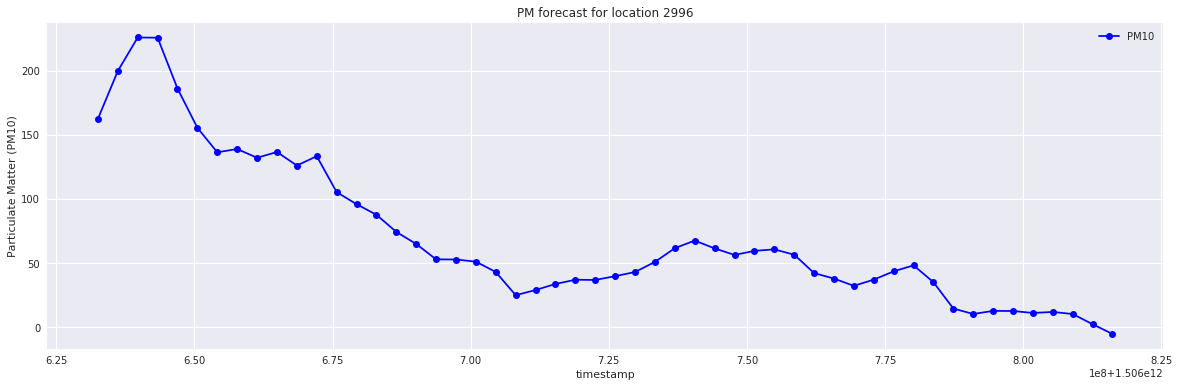

In [37]:
ax = df_2996.plot(kind='line', x='timestamp',y='PM10',marker='o',color='blue')
ax.set_ylabel('Particulate Matter (PM10)');
ax.set_title("PM forecast for location 2996")

#### PM forecast for location 2975

Text(0.5,1,'PM forecast for location 2975')

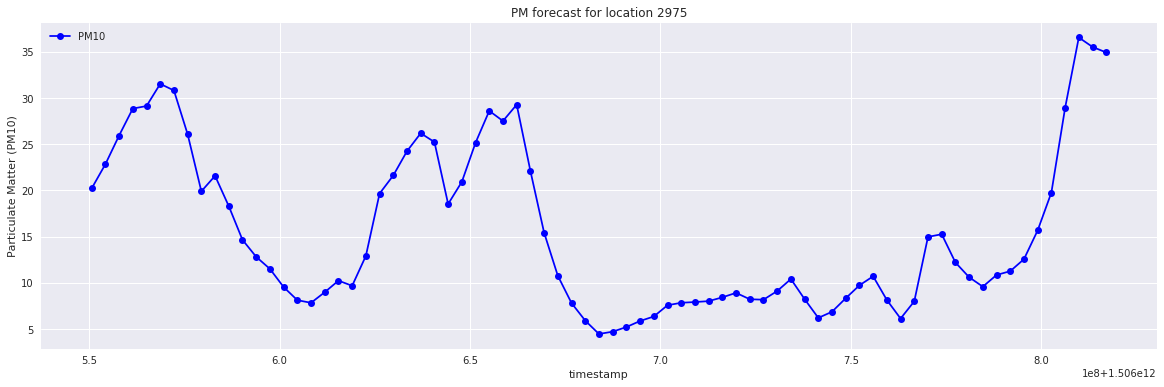

In [38]:
ax = df_2975.plot(kind='line', x='timestamp',y='PM10',marker='o', linestyle='-',color='blue')
ax.set_ylabel('Particulate Matter (PM10)');
ax.set_title("PM forecast for location 2975")